# Basic Tutorial for GEORGE

In this notebook, we demonstrate a simple experiment comparing empirical risk minimization (ERM) and our method (GEORGE) on the MNIST dataset, using a small three-layer CNN model. In this simple example, GEORGE improves worst-case accuracy (i.e., the minimum accuracy over any subclass) compared to ERM. More sophisticated experiments are described in the blog post (and paper, coming soon). The notebook can be run with or without GPU support. For a script version rather than a notebook, see `stratification/run.py`.

There are four main sections to this notebook:
1. **Setup**: Imports and setting up the datasets.
2. **Train ERM Model**: we train an empirical risk minimization (ERM) model on the `superclass` labels.
3. **Cluster Activations**: using the feature representation of the ERM model, we leverage dimensionality reduction and clustering techniques in order to estimate approximate `subclass` labels for each example.
4. **Train DRO Model**: we train a new model that exploits the recovered `subclass` labels to improve worst-case performance on them, using group distributionally robust optimization (GDRO) [Sagawa et al. (2020)].

## 1. Setup and data loading

### 1.1 Imports and configuration setup
Before you start, make sure you have set up the repository correctly and installed all dependencies, as described in the README.

All training options are handled by a single `config` object. In this tutorial, we make use of the configuration provided in `default_config.json`. To see how configuration files are defined, validated, and (optionally) modified via the command line, check out `stratification/utils/parse_args.py` and `stratification/utils/schema.py`.

In [1]:
import os
import json
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from stratification.harness import GEORGEHarness
from stratification.classification.models import ShallowCNN
from stratification.classification.datasets import MNISTDataset, DATA_SPLITS
from stratification.cluster.models.cluster import GaussianMixture
from stratification.cluster.models.reduction import UMAPReducer
from stratification.utils.utils import set_seed
from stratification.utils.parse_args import get_config

# repository base directory
os.chdir('../')
REPO_DIR = os.getcwd()

with open('configs/demo_config.json', 'r') as f:
    config = json.dumps(json.load(f))
config = get_config([config])

os.chdir(os.path.join(REPO_DIR, 'stratification'))

use_cuda_if_available = False  # change to True if you want to use CUDA
use_cuda = use_cuda_if_available and torch.cuda.is_available()
set_seed(config['seed'], use_cuda)  # set seeds for reproducibility

### 1.2 Load Data

In this tutorial, we'll use the MNIST dataset. In our case, the task will be to classify digits as < 5 or ≥ 5; these correspond to the two *superclasses*. The *subclasses* are the individual digits (0,1,2,3,4 are the subclasses of the first superclass, and 5,6,7,8,9 are the subclasses of the second superclass).

In [2]:
DATA_DIR = os.path.join(REPO_DIR, 'data')

dataset_class = MNISTDataset

# Use mild data augmentation during training
transform_train = transforms.Compose([
    transforms.RandomCrop(dataset_class._resolution, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(**dataset_class._normalization_stats)
])
transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**dataset_class._normalization_stats)
])

dataloaders = {}
for split in DATA_SPLITS:
    if split == 'train':
        # Training dataloader uses transform_train transforms, and is shuffled
        dataset = dataset_class(root=DATA_DIR, split=split, transform=transform_train, download=True)
        dataloaders[split] = DataLoader(dataset, shuffle=True, batch_size=128, num_workers=8)
    else:
        # Evaluation dataloaders (including for the training set) are "clean" - no data augmentation or shuffling
        key = 'train' if split == 'train_clean' else split
        dataset = dataset_class(root=DATA_DIR, split=key, transform=transform_eval)
        dataloaders[split] = DataLoader(dataset, shuffle=False, batch_size=128, num_workers=8)

## 2. Train ERM Model

### 2.1. Initialize Classification Model

First, we build our classifier. Any `nn.Module` object will do; see `stratification/classification/models/shallow_cnn.py` for the definition of the CNN architecture used in this notebook.

In [3]:
model = ShallowCNN(num_classes=2)
print('Model architecture:')
print(model)

# specify layer for which to save activations
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
    print('Using CUDA')
state_dict = deepcopy(model.state_dict())

Model architecture:
ShallowCNN(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
  )
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


### 2.2. Initialize GEORGEHarness

The GEORGEHarness is an object that handles the "bookkeeping" for each of the steps outlined in this tutorial, such as setting up experiment directories and loading/saving models.  Experiment files are stored in the base directory specified by `config['exp_dir']` in the configuration. Each experiment run is stored in a subdirectory of this base directory whose filename is based on the (1) optimization technique (ERM, GEORGE, etc.), (2) the timestamp, and (3) a random hash (to avoid collisions).

In [4]:
harness = GEORGEHarness(config['exp_dir'], use_cuda=use_cuda, log_format='simple')

### 2.3. Run `harness.classify`

Now, we're ready to train a classifier! First we'll just train a standard classifier using empirical risk minimization (a fancy term for minimizing the average training loss). We'll print out both the overall accuracy and the true robust accuracy (in other words, the minimum accuracy on any subclass), and the losses as well. The robust accuracy is the metric we are interested in maximizing. We train our models as though we don't know the subclass (digit) labels, in which case we can't actually measure the robust accuracy - but in this case, we do know the subclass labels, so we'll print it out just to see how well our methods really do.

In [5]:
erm_dir = harness.classify(config['classification_config'],  model, dataloaders, 'erm')

Config saved in: checkpoints/tutorial/erm_2020-07-01_20-45-15_53c44b0b
Starting training.

Epoch: [1 | 20] LR: 5.00E-03
Training:
Loss: 0.469, Acc.: 78.03%, True robust loss: 0.750, True robust acc.: 59.43%
Validation:
Loss: 0.321, Acc.: 86.61%, True robust loss: 0.646, True robust acc.: 65.74%

Epoch: [2 | 20] LR: 5.00E-03
Training:
Loss: 0.357, Acc.: 85.06%, True robust loss: 0.649, True robust acc.: 66.63%
Validation:
Loss: 0.275, Acc.: 89.46%, True robust loss: 0.589, True robust acc.: 69.25%

Epoch: [3 | 20] LR: 5.00E-03
Training:
Loss: 0.322, Acc.: 86.91%, True robust loss: 0.567, True robust acc.: 72.88%
Validation:
Loss: 0.254, Acc.: 90.03%, True robust loss: 0.470, True robust acc.: 80.54%

Epoch: [4 | 20] LR: 5.00E-03
Training:
Loss: 0.298, Acc.: 88.07%, True robust loss: 0.521, True robust acc.: 75.78%
Validation:
Loss: 0.233, Acc.: 90.88%, True robust loss: 0.495, True robust acc.: 76.35%

Epoch: [5 | 20] LR: 5.00E-03
Training:
Loss: 0.284, Acc.: 88.60%, True robust loss: 0

The overall accuracy is around **92.5%**, but the robust accuracy is quite a bit lower at around **86.5%** on the test set. (Note: Results may vary based on random seed, platform, whether a GPU is used, etc.) Let's see if we can improve on this!

## 3. Cluster Model Activations

Now, we will cluster the data of each superclass, to try and automatically identify the subclasses. However, just clustering the raw data usually doesn't work that well - instead, we cluster in the *feature space* of a trained model. We just trained an ERM model on the task, so we'll now use this model to extract features which we use for clustering. Specifically, the features are the activations (outputs) of the penultimate layer (right before the classification layer).

### 3.1. Initialize Cluster Model and Reduction Model

The clustering procedure consists of two steps:
1. Dimensionality reduction of the activations (optional). If `reduction_model` is `None`, the raw activations are used.
2. Fitting a separate cluster model on the reduced training activations of each superclass.

We'll use UMAP for dimensionality reduction, and we'll use Gaussian mixture model clustering. For simplicity, in this tutorial we fix the number of clusters per superclass to 5 (the true number of subclasses per superclass for this task). *Automatic* selection of the number of clusters based on unsupervised metrics (such as the Silhouette score) is also supported - in fact, our experiments in the blog post and paper were run using this automatic selection procedure, rather than pre-specifying the number of clusters. Scripts to reproduce all our experiments will be made available soon.

In [6]:
reduction_model = UMAPReducer(
    random_state=12345,
    n_components=2,
    n_neighbors=10,
    min_dist=0,
)

cluster_model = GaussianMixture(
    covariance_type="full",
    n_components=5,
    n_init=3,
)

### 3.2. Run `harness.cluster`

Now we run the actual clustering (including the dimensionality reduction). This step also generates and saves visualizations of the data, which we'll look at in the next part.

In [7]:
cluster_dir = harness.cluster(config['cluster_config'], 
                              cluster_model, 
                              inputs_path=os.path.join(erm_dir, 'outputs.pt'), 
                              reduction_model=reduction_model)

Config saved in: checkpoints/tutorial/erm_2020-07-01_20-45-15_53c44b0b/cluster_2020-07-01_20-47-59_d1f852bf
Reducing superclass 0...
Clustering superclass 0...
Reducing superclass 1...
Clustering superclass 1...
Saving checkpoint to checkpoints/tutorial/erm_2020-07-01_20-45-15_53c44b0b/cluster_2020-07-01_20-47-59_d1f852bf/clusters.pt...


<Figure size 432x288 with 0 Axes>

### 3.3. Visualizing the clusters

Now let's look at the clusters that we found. Note that since we apply UMAP to reduce to dimension 2, we can directly visualize the data in this two-dimensional "feature space" - see below! The first row corresponds to the first superclass (< 5, i.e. digits 0-4) and the second row corresponds to the second superclass (≥ 5, i.e. digits 5-9). On the left, we color each point by its assigned cluster label. On the right, we color each point by its actual subclass (i.e., which digit that datapoint is). As we can see, the individual subclasses are fairly easy to distinguish in feature space, and as a result *up to permutation* the clusters we find match up quite well with the actual subclasses.

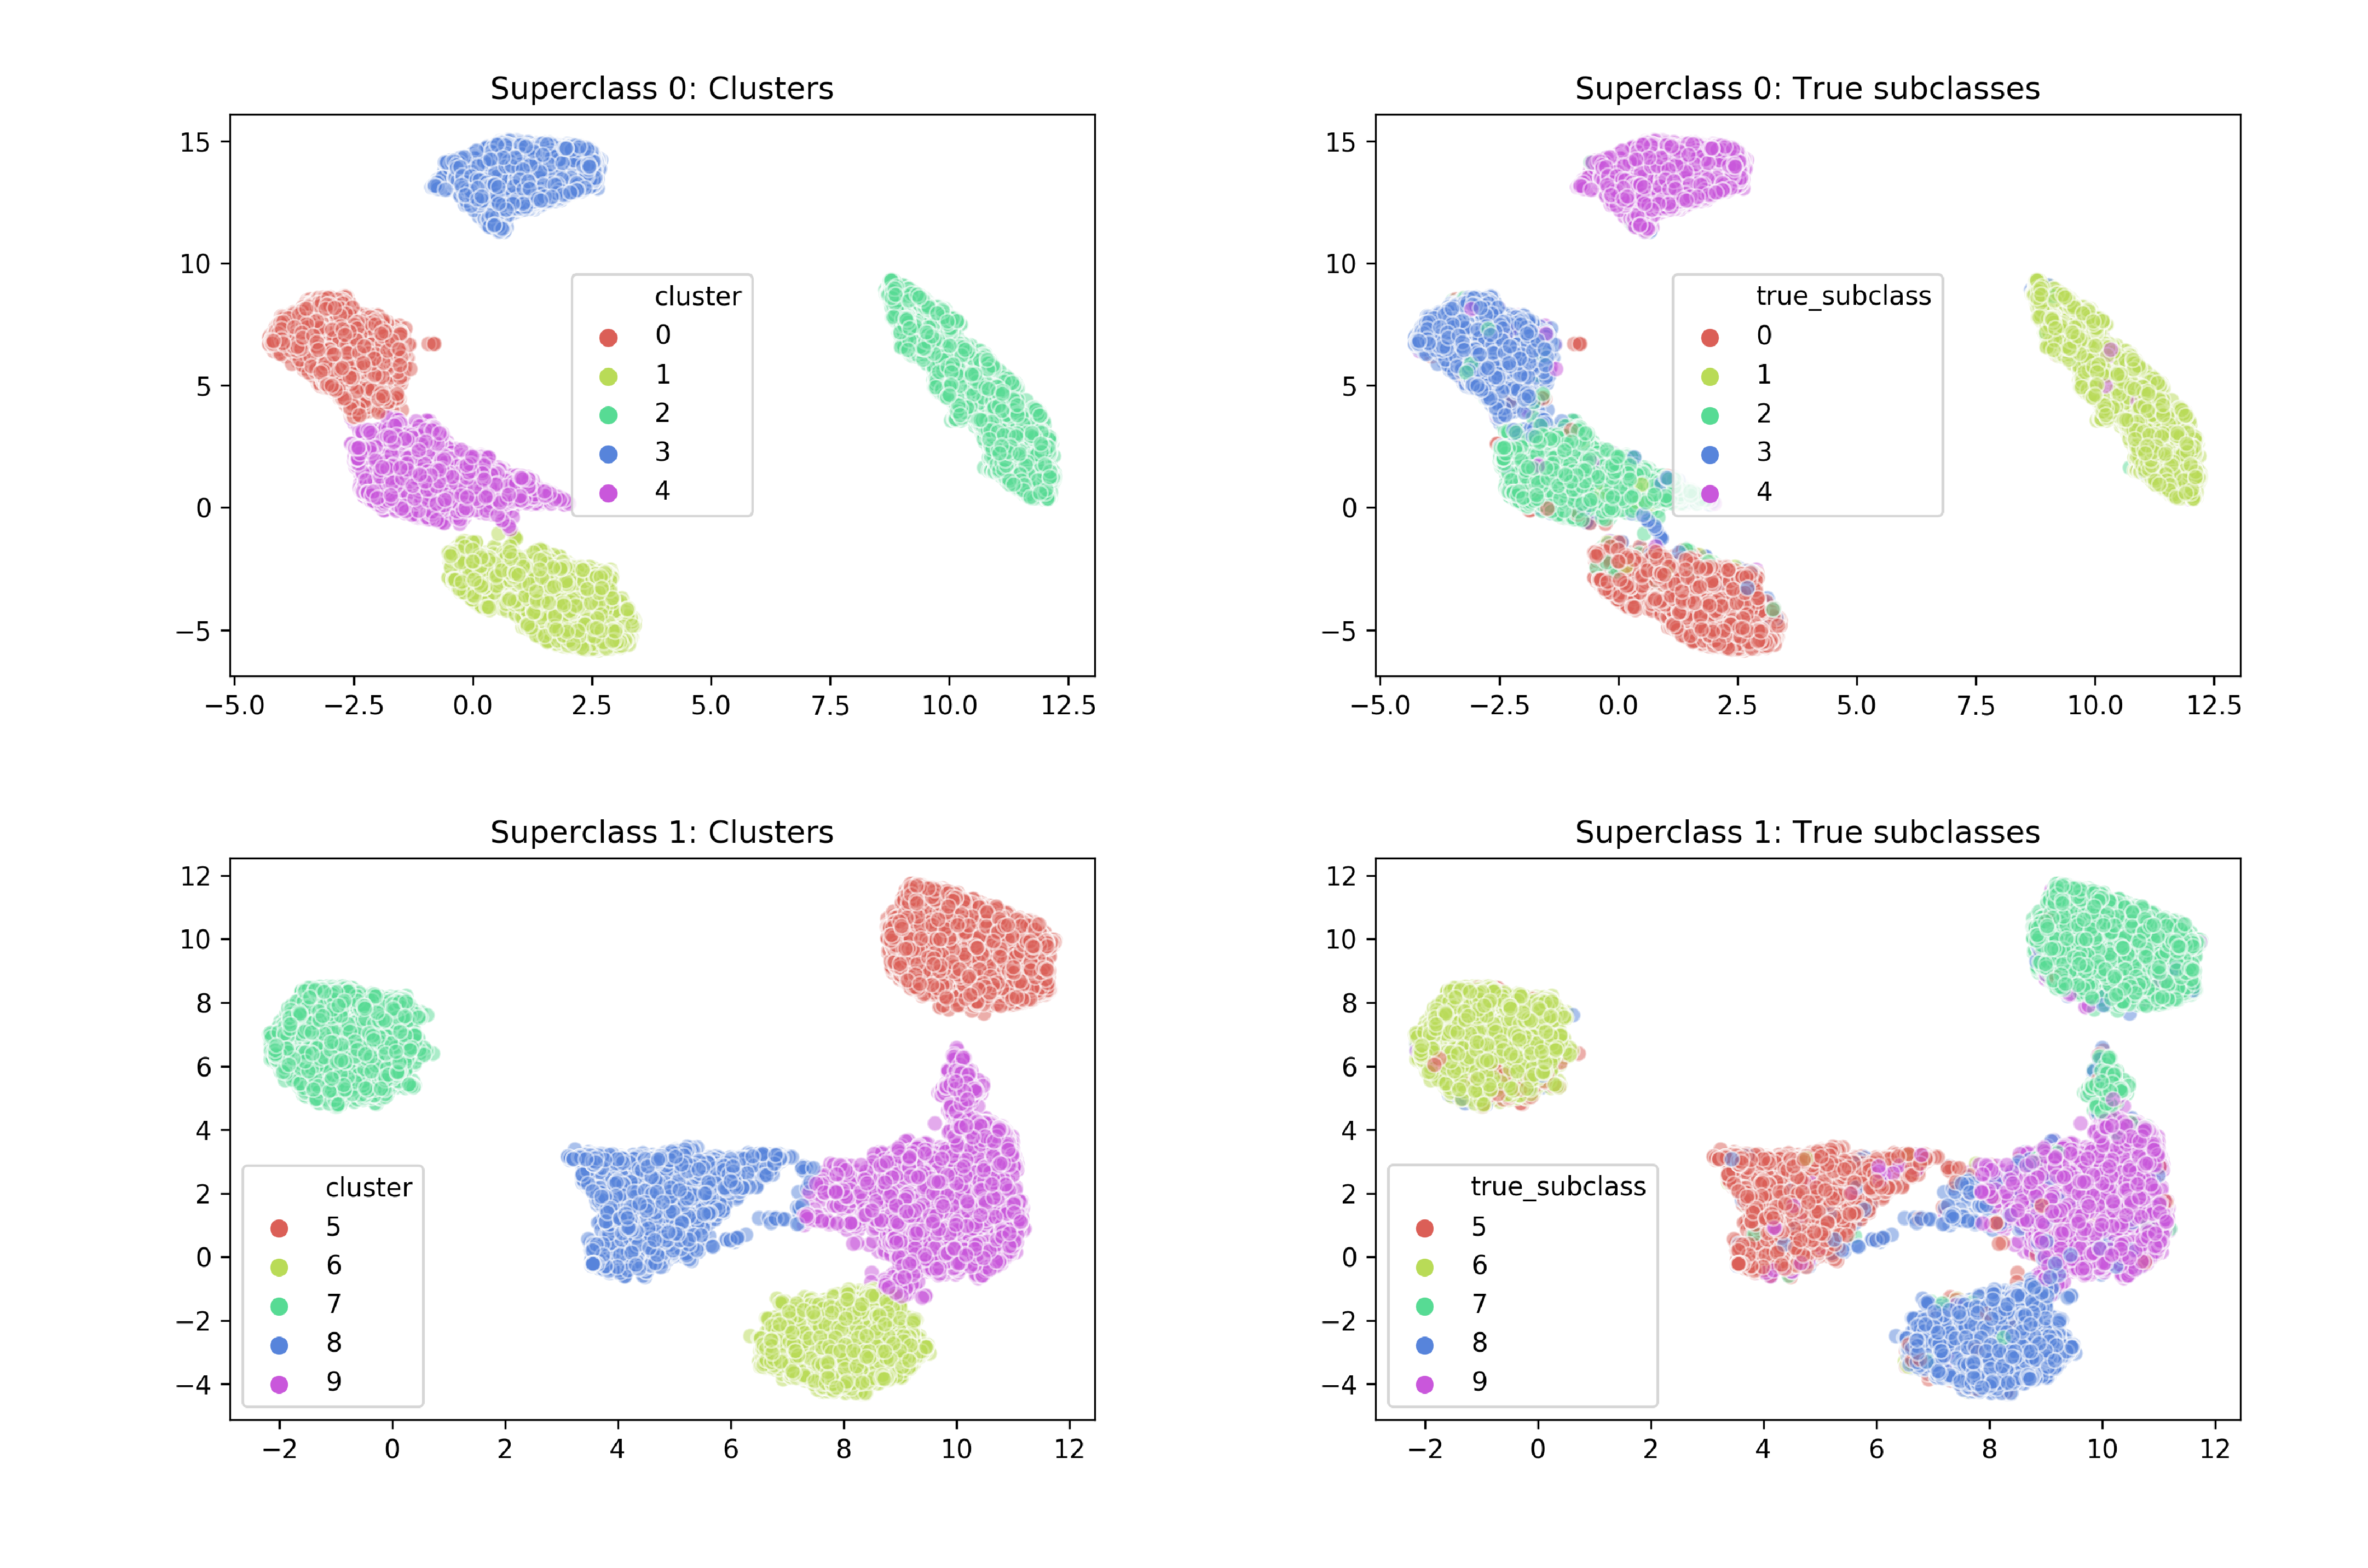

In [8]:
viz_dir = os.path.join(cluster_dir, 'visualizations')
fig, axarr = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True, dpi=300)
for i in range(2):
    axarr[i, 0].imshow(mpimg.imread(os.path.join(viz_dir, f'train/group_{i}_cluster_viz.png')))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(os.path.join(viz_dir, f'train/group_{i}_true_subclass_viz.png')))
    axarr[i, 1].axis('off')

## 4. Train Final (GEORGE) Model

Training the GEORGE model is simple. The only new thing to pass in is the `clusters.pt` path. This is a pickled dictionary saved by `harness.cluster` that contains the cluster labels assigned to the datapoints. These estimated cluster labels are used as a surrogate for the subclass labels. We now train a model to minimize the *worst-case* loss over the clusters using GDRO. Since the cluster assignments are fairly similar to the true subclass labels up to permutation, we expect that this procedure should improve worst-case accuracy on the true subclasses as well.

As before, we'll print out both the overall and the true robust accuracy and loss. We'll also print out the *estimated* robust accuracy, which is the minimum accuracy on any *cluster*. Unlike the true robust accuracy, this is something we can actually measure even if we don't know the true subclass labels - and if the cluster labels are a good estimate of the true subclass labels, then this estimated robust accuracy should be a good estimate of the true robust accuracy.

In [9]:
model.load_state_dict(state_dict)  # reset model state
george_dir = harness.classify(config['classification_config'], 
                              model, 
                              dataloaders, 
                              'george', 
                              clusters_path=os.path.join(cluster_dir, 'clusters.pt'))

Config saved in: checkpoints/tutorial/george_2020-07-01_20-49-53_16b2303b
Starting training.

Epoch: [1 | 20] LR: 5.00E-03
Training:
Loss: 0.459, Acc.: 80.25%, Est. rob. loss: 0.608, Est. rob. acc: 67.13%, True rob. loss: 0.626, True rob. acc: 65.79%
Validation:
Loss: 0.338, Acc.: 87.53%, Est. rob. loss: 0.489, Est. rob. acc: 78.78%, True rob. loss: 0.484, True rob. acc: 78.80%

Epoch: [2 | 20] LR: 5.00E-03
Training:
Loss: 0.355, Acc.: 86.20%, Est. rob. loss: 0.392, Est. rob. acc: 82.08%, True rob. loss: 0.409, True rob. acc: 81.18%
Validation:
Loss: 0.299, Acc.: 88.49%, Est. rob. loss: 0.435, Est. rob. acc: 79.74%, True rob. loss: 0.432, True rob. acc: 80.62%

Epoch: [3 | 20] LR: 5.00E-03
Training:
Loss: 0.323, Acc.: 87.04%, Est. rob. loss: 0.353, Est. rob. acc: 84.76%, True rob. loss: 0.377, True rob. acc: 82.94%
Validation:
Loss: 0.269, Acc.: 90.33%, Est. rob. loss: 0.451, Est. rob. acc: 81.35%, True rob. loss: 0.446, True rob. acc: 81.33%

Epoch: [4 | 20] LR: 5.00E-03
Training:
Los

The overall accuracy is similar to that of the ERM model, but the robust accuracy has improved to around **89%**!
In addition, our estimate of the robust accuracy is quite close to the actual robust accuracy (within 1%; in fact, the two metrics remain quite close throughout the entire training run).
(Again, note that results may vary somewhat - but on average across random seeds, the GEORGE model indeed outperforms the ERM one in terms of robust accuracy.)

## Conclusion

This notebook demonstrates our framework (GEORGE) for estimating subclasses and improving worst-case subclass accuracy, on a simple "toy" example. Although the end-to-end performance gains are modest in this case, on more complex datasets the gains can be quite dramatic! See our blog post for more details.